# Mini Projet 2024 - à quoi tu ressembles sans ton masque ?

Avec la pandémie de la Covid-19, nous avons appris à porter des masques quotidiennement. 
Désormais la moitié de notre visage est cachée nous laissant le regard pour seul moyen d'expression visible. Cette opération de restaurer le visage s'apparente à un domaine en traitement d'images et de vidéos appelé **inpainting**. En effet, les pixels correspondant à la zone du masque (modélisé par un rectangle) sont mis à 0. Et l'ACP et les **eigenfaces** permettent, entre autres, de restaurer la zone dégradée.  


L'**objectif de ce mini projet** consiste à combler la zone de masque par un visage qui est le plus semblable à l'aide de l'ACP et des $k$ plus proches voisins.

In [1]:
import numpy as np
import sklearn
import matplotlib.pyplot as plt
from matplotlib import image
from random import *

## Chargement des données

La base de données sur laquelle ce projet est appliqué est une collection d'images utiles pour mener des expériences en psychologie (*Psychological Image Collection at Stirling* (PICS) :http://pics.stir.ac.uk). 

<img src="files/base.PNG" width="800" height="600"  >

Elle comporte 32 personnes (16 hommes et 16 femmes) avec 6 postures/expressions  faciales : 2 postures (face et trois quart face) et 3 émotions différentes par posture.



Text(0.5, 1.0, 'Exemple de visage')

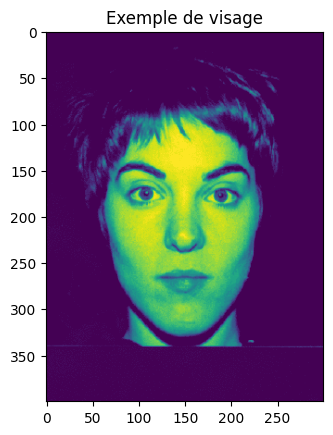

In [2]:
# Chargement des données de visages entiers : 192 x 120000
X_Data=np.load('Data.npy')

# Dimensions des images
nblignes=400
nb_colonnes=300

plt.imshow(np.reshape(X_Data[0,:],(nblignes,nb_colonnes))) 
plt.title('Exemple de visage')

Text(0.5, 1.0, 'Exemple de visage masqué')

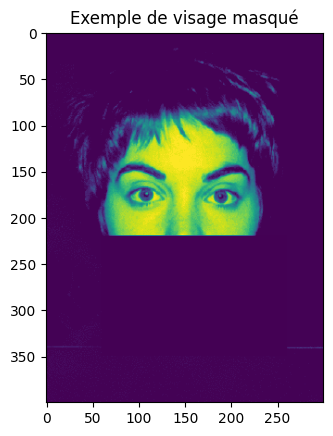

In [3]:
# Chargement des données de visages masqués : 192 x 120000
X_DataMask=np.load('DataMask.npy')

plt.imshow(np.reshape(X_DataMask[0,:],(nblignes,nb_colonnes))) 
plt.title('Exemple de visage masqué')

# Création base d'apprentissage

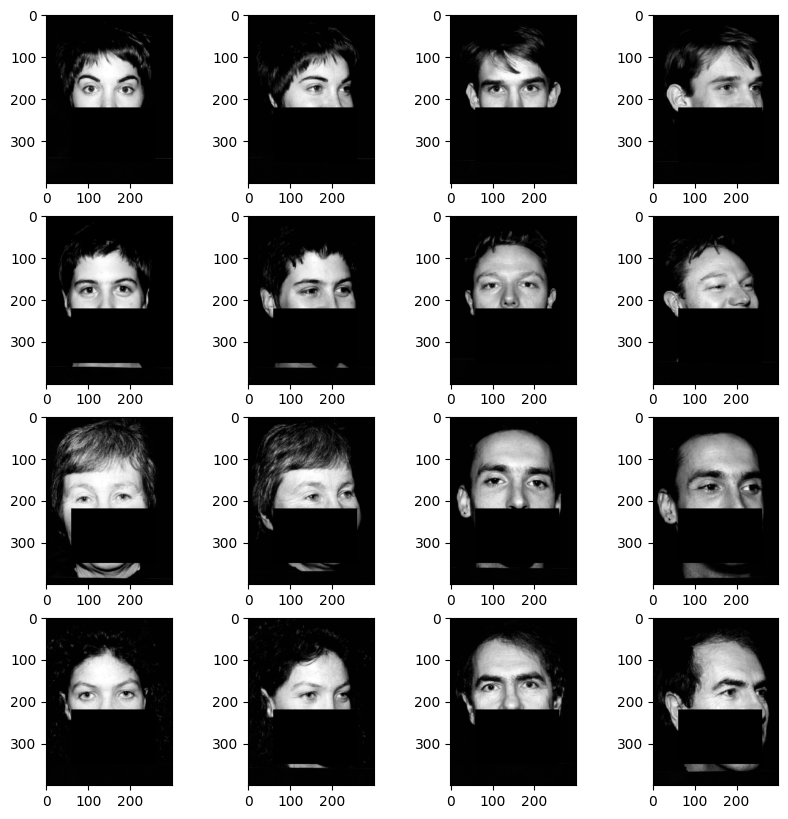

In [62]:
# Création de la base d'apprentissage : exemple à modifier
X_App=X_DataMask[np.arange(0,48,3),:] 
X_test=X_Data[np.arange(0,48,3),:]

# Affichage des visages masqués de la base d'apprentissage
plt.figure(figsize=(10,10))
compt=0
for i in range(0,X_App.shape[0]):
    im=np.reshape(X_App[i,:],(400,300))
    plt.subplot(4,4,compt+1)
    compt=compt+1
    plt.imshow(im,cmap='gray')
    
plt.show()    



##  Eigenfaces et réduction de dimensions par ACP

Complétez la fonction *eigenfaces*, qui vise à calculer les axes
principaux des images d'apprentissage à partir des vecteurs propres associés
aux $n-1$ valeurs propres non nulles de la matrice de variance/covariance
$\Sigma$ des données/.


La notion d'eigenfaces provient du travail de M. Turk et A. Pentland intitulé «Eigenfaces for
Recognition» : https://www.mitpressjournals.org/doi/pdfplus/10.1162/jocn.1991.3.1.71 

<img src="files/Eigenfaces.PNG" width="600" height="500"  >

**Remarque :**  la
    fonction *np.linalg.eig* ne peut pas être directement appliquée à $\Sigma$. En
    effet, sa taille $p\times p$ est gigantesque ($p = 120000$). Or, pour une
    matrice $\text{M}$ quelconque, $\text{M}^\top \text{M}$ et
    $\text{M}\,\text{M}^\top$ ont les mêmes valeurs propres \emph{non nulles}.
    On peut donc appliquer la fonction \verb!eig! à $\Sigma_2 = \text{X}_c \,
    \text{X}_c^\top/n$, de taille $n\times n$ beaucoup plus petite, pour
    calculer les valeurs propres non nulles de $\Sigma$.

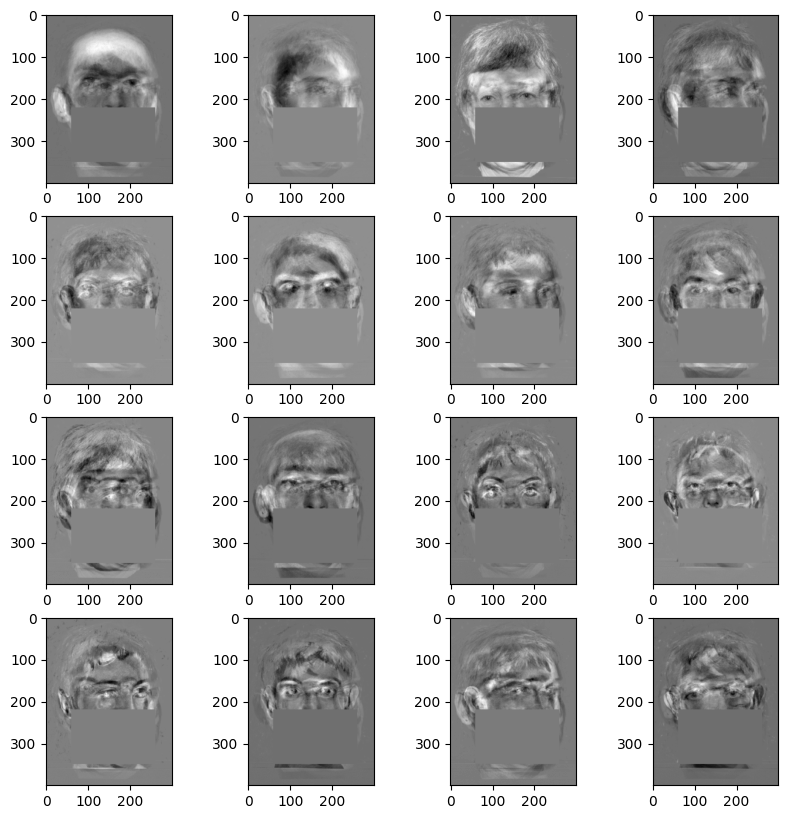

(array([[-2.65219088e+03, -7.18032127e+03,  6.06443714e+03,
          5.63914928e+03,  4.52870071e+02, -9.95132025e+02,
         -1.22009680e+01,  8.75805267e+03, -6.38594822e+02,
         -2.00104948e+03,  2.25893126e+03, -1.95277508e+03,
          9.11763960e+02,  5.92802463e+03,  1.24117833e+03,
          2.53707184e+03],
        [-1.99213523e+03,  4.31815083e+03,  7.96425619e+03,
          2.76832236e+03,  1.49434084e+03, -3.25822002e+03,
         -1.05174928e+02,  4.63566540e+03, -1.53756032e+02,
         -1.86716688e+03, -1.48497451e+03, -2.01445152e+03,
         -6.54804158e+02,  8.81150071e+02, -3.76003175e+03,
          2.34660517e+03],
        [-1.77344128e+03, -5.55428380e+03,  4.64242914e+03,
          7.18794416e+03, -1.69036769e+03,  2.28339759e+02,
         -2.40465258e+03,  7.61936914e+02, -2.62611149e+03,
          3.48548059e+03, -1.37519348e+03, -3.06291063e+03,
         -7.02841720e+02,  5.96434995e+03, -1.17309857e+03,
         -1.35441522e+03],
        [ 1.6780248

In [13]:
def eigenface(X_App):
  # Center the data
  X_mean = np.mean(X_App, axis=0)
  X_centered = X_App - X_mean

  # Compute the covariance matrix
  covariance_matrix1 = np.dot(X_centered, X_centered.T) / X_centered.shape[0]

  # Compute the eigenvalues and eigenvectors of the smaller covariance matrix  sigma 2
  eigenvalues, eigenvectors_small = np.linalg.eig(covariance_matrix1)

  # Transform the eigenvectors back to the original space
  vectore2 = np.dot(X_centered.T, eigenvectors_small) #vector propre de matrice de cov 1 sigma 1
  
  # Normalize the eigenvectors
  vectore2 = vectore2 / np.linalg.norm(vectore2, axis=0)
  
  #affichage images
  plt.figure(figsize=(10, 10))
  compt = 0
  for i in range(vectore2.shape[1]):
    im = np.reshape(vectore2[:, i], (400, 300))
    plt.subplot(4, 4, compt + 1)
    compt = compt + 1
    plt.imshow(im, cmap='gray')
  plt.show()
  
  composante = np.dot(X_App, vectore2)   #composante principale (nombre d'images, nombre d'eigenfaces)
 #pour chaque eigenface, le code calcule la projection de toutes les images X_App sur cette eigenface vectore2[:, i]. errer 

  return composante,vectore2

eigenface(X_App)


## Reconnaissance par kppv

En tirant aléatoirement une image de test, parmi les 32 personnes et les 6 postures faciales disponibles dans la base de données complète, complétez une fonction pour trouver l'individu (personne+posture) et la distance du proche voisin dans la base d'apprentissage qui est le plus proche de l'image de test (vous pouvez utiliser et adapter la fonction \texttt{kppv} que vous avez écrite lors du TP2). 

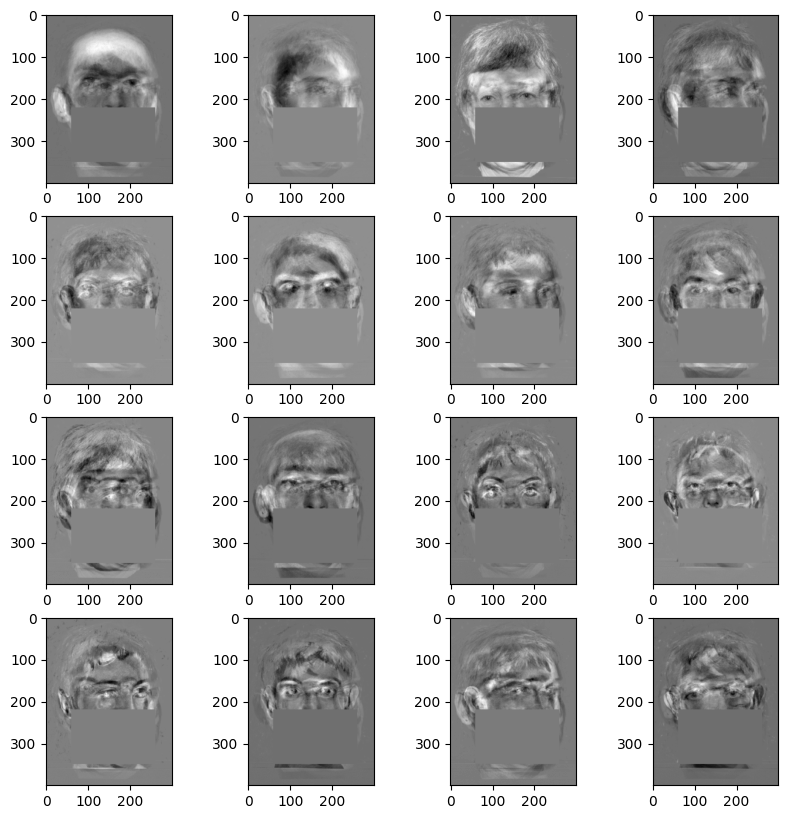

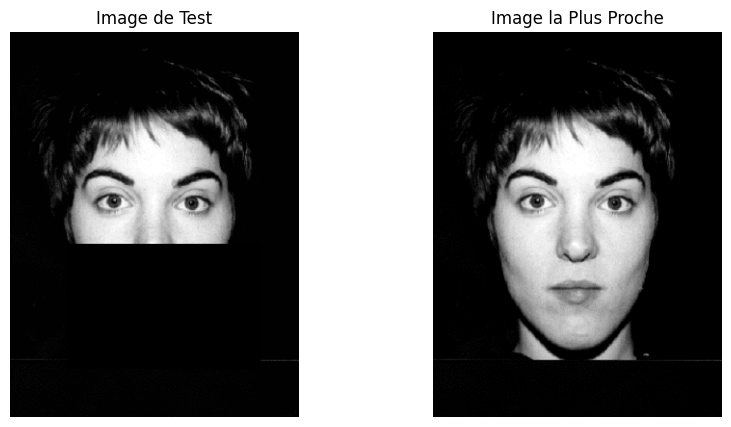

In [ ]:
def k_nearest_neighbor(query, data, eigenfaces, k=1):
    """
    Trouve l'image la plus proche de l'image de test dans la base d'apprentissage en utilisant k-plus proches voisins.
    query : image de test vectorisée
    data : base d'apprentissage vectorisée
    eigenfaces : eigenfaces pour projeter les données
    k : nombre de voisins proches (défaut à 1)
    """
    # Projection des images sur les eigenfaces (réduction de dimension)
    projected_data = np.dot(data, eigenfaces)
    projected_query = np.dot(query, eigenfaces)
    
    # Calcul des distances euclidiennes entre l'image de test et les images de la base
    distances = np.linalg.norm(projected_data - projected_query, axis=1)
    
    # Tri des distances et retour des indices des k plus proches voisins
    nearest_neighbors = np.argsort(distances)[:k]
    
    return nearest_neighbors
  
composante, vectore2 = eigenface(X_App)
query = X_App[0] #image de test 
nearest_neighbor_index = k_nearest_neighbor(query, X_DataMask, vectore2, k=1)[0]
closest_image = X_test[nearest_neighbor_index]

# Affichage de l'image de test et de l'image la plus proche
def display_images(test_img, closest_img, img_shape=(400, 300)):
    test_img_reshaped = np.reshape(test_img, img_shape)
    closest_img_reshaped = np.reshape(closest_img, img_shape)
    
    plt.figure(figsize=(10, 5))
    
    # Affiche l'image de test
    plt.subplot(1, 2, 1)
    plt.imshow(test_img_reshaped, cmap='gray')
    plt.title("Image de Test")
    plt.axis('off')
    
    # Affiche l'image la plus proche
    plt.subplot(1, 2, 2)
    plt.imshow(closest_img_reshaped, cmap='gray')
    plt.title("Image la Plus Proche")
    plt.axis('off')
    
    plt.show()

# Affiche l'image de test et l'image la plus proche
display_images(query, closest_image, img_shape=(400, 300))

## Reconstruction 

A partir de la question précédente, implémentez la reconstruction de la zone du masque  en remplaçant la zone correspondant au masque par la zone de l'image de la base d'apprentissage de visages entiers la plus proche dans l'espace défini par les eigenfaces masqués.



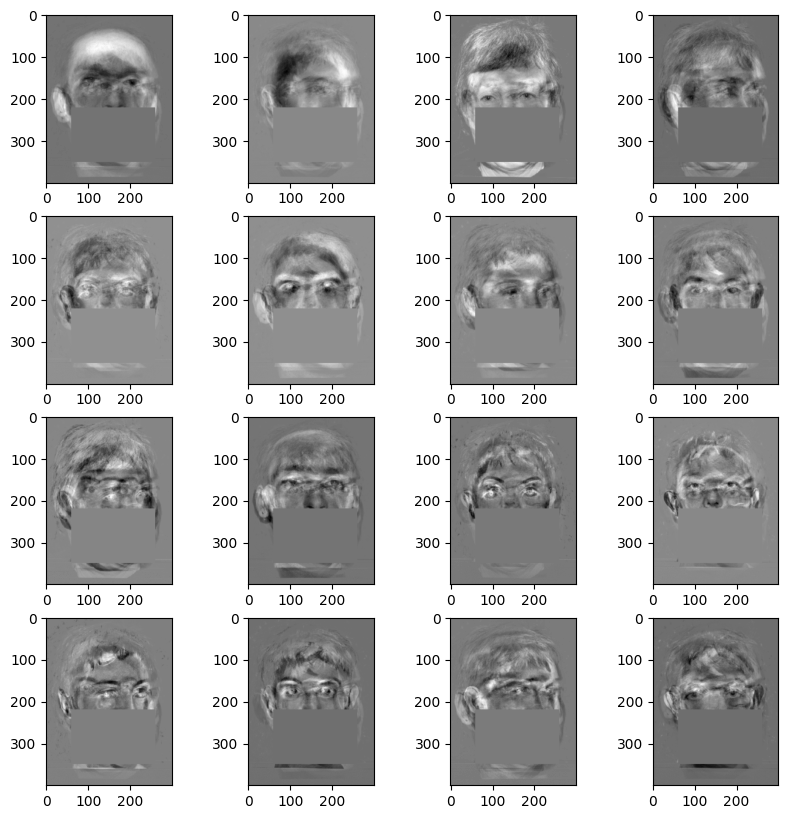

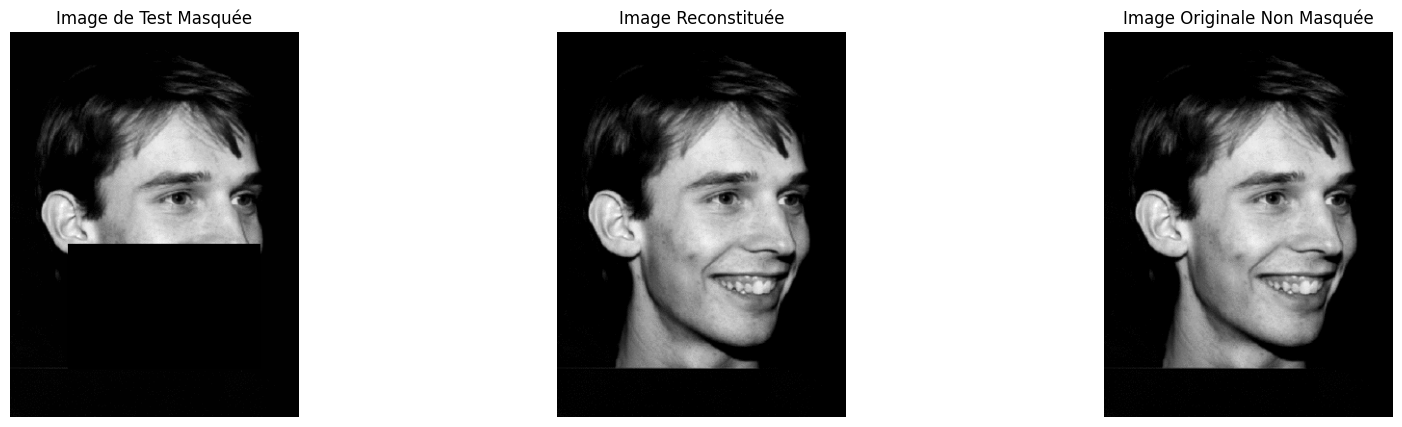

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Dimensions du masque
ligne_min, ligne_max = 220, 350
colonne_min, colonne_max = 60, 260
img_shape = (400, 300)

def create_mask(shape, ligne_min, ligne_max, colonne_min, colonne_max):
    mask = np.zeros(shape, dtype=bool)
    mask[ligne_min:ligne_max, colonne_min:colonne_max] = True
    return mask

# Génération du masque
mask = create_mask(img_shape, ligne_min, ligne_max, colonne_min, colonne_max)

def reconstruct_image(masked_image, unmasked_image, mask):
    reconstructed_image = np.copy(masked_image)
    reconstructed_image[mask] = unmasked_image[mask]
    return reconstructed_image

# Supposons que eigenface et k_nearest_neighbor sont déjà définis
composante, vectore2 = eigenface(X_App)
X_App_mean = np.mean(X_App, axis=0)

# Sélection de l'image de test masquée et recherche du plus proche voisin
query_masked = X_App[3] - X_App_mean  # Centrer l'image de test masquée
nearest_neighbor_index = k_nearest_neighbor(query_masked, X_test, vectore2, k=1)[0]

# Récupérer l'image non masquée correspondante dans X_test
closest_unmasked_image = X_test[nearest_neighbor_index]

# Reshape des images pour application du masque
query_masked_reshaped = np.reshape(query_masked + X_App_mean, img_shape)
closest_unmasked_image_reshaped = np.reshape(closest_unmasked_image, img_shape) #je stocke dans ce variable just la partie de mask correspond 

# Reconstruction de l'image de test en utilisant la zone du masque de l'image non masquée la plus proche
reconstructed_image = reconstruct_image(query_masked_reshaped, closest_unmasked_image_reshaped, mask)

def display_images(masked_img, reconstructed_img, original_unmasked_img):
    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 3, 1)
    plt.imshow(masked_img, cmap='gray')
    plt.title("Image de Test Masquée")
    plt.axis('off')
  
    plt.subplot(1, 3, 2)
    plt.imshow(reconstructed_img, cmap='gray')
    plt.title("Image Reconstituée")
    plt.axis('off')
    
    plt.subplot(1, 3, 3)
    plt.imshow(original_unmasked_img, cmap='gray')
    plt.title("Image Originale Non Masquée")
    plt.axis('off')
    
    plt.show()

# Affichage
display_images(query_masked_reshaped, reconstructed_image, closest_unmasked_image_reshaped)

# Evaluation

Pour l'évaluation, une possibilité serait d'estimer la distribution des distances au plus proche voisin dans le cas de la même personne avec une émotion différente et une posture différente.

En fonction de cette distribution, on peut définir une distance seuil à partir de laquelle on peut envoyer un message en précisant que 
-la personne la + proche n'est pas la bonne personne associée à l'image requête 

**Autre piste :** Affiner l'étude aussi lorsque la personne idenfiée correspond à l'image requête avec une autre distance spécifique pour une posture différente voire pour une émotion différente ? Plein de possiblités pour cette étude sur l'évaluation de la reconstruction.

In [ ]:
def evaluate_classifier(test_images, train_images, eigenfaces, labels, reconstruct=False):
    """
    Évalue la précision du classifieur 1-plus proche voisin.
    test_images : liste d'images de test
    train_images : liste d'images d'apprentissage
    eigenfaces : eigenfaces pour projection
    labels : étiquettes associées aux images de la base d'apprentissage
    reconstruct : booléen pour activer la reconstruction d'image
    """
    correct_matches = 0
    total_tests = len(test_images)
    
    # Pour évaluer la distance des voisins et les correspondances
    distances = []

    for test_image, true_label in zip(test_images, labels):
        # Trouver l'indice du voisin le plus proche
        nearest_neighbor_idx = k_nearest_neighbor(test_image, train_images, eigenfaces, k=1)[0]
        predicted_label = labels[nearest_neighbor_idx]

        # Calculer la distance (ajoutez la méthode de calcul de distance ici)
        distance = np.linalg.norm(test_image - train_images[nearest_neighbor_idx])
        distances.append(distance)

        if predicted_label == true_label:
            correct_matches += 1

        # Si la reconstruction est activée
        if reconstruct:
            # Reconstruire l'image en utilisant le voisin le plus proche
            reconstructed_image = reconstruct_image(test_image, train_images[nearest_neighbor_idx], mask)  # Assumez que mask est défini

            # Afficher les résultats de la reconstruction
            display_images(test_image, reconstructed_image)

    # Calcul de la précision
    accuracy = correct_matches / total_tests
    return accuracy, distances

# Fonction pour tester les différentes configurations
def test_different_configurations(test_images, train_images, eigenfaces, labels):
    """
    Teste les différentes configurations pour l'évaluation de la reconnaissance.
    """
    # Configuration 1 : Images de test avec des personnes de la base d'apprentissage (expressions différentes)
    # (Supposons que vous avez une liste `test_images_different_expressions`)
    accuracy1, distances1 = evaluate_classifier(test_images_different_expressions, train_images, eigenfaces, labels)
    
    print(f"Précision avec des expressions différentes : {accuracy1 * 100:.2f}%")
    print("Distances pour cette configuration :", distances1)

    # Configuration 2 : Images de test avec des personnes qui ne figurent pas dans la base d'apprentissage
    # (Supposons que vous avez une liste `test_images_not_in_train`)
    accuracy2, distances2 = evaluate_classifier(test_images_not_in_train, train_images, eigenfaces, labels)

    print(f"Précision avec des personnes non présentes dans la base d'apprentissage : {accuracy2 * 100:.2f}%")
    print("Distances pour cette configuration :", distances2)


# Créez des étiquettes pour vos images
labels_train = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * 5)[:16]  # Adapté en fonction de vos données
labels_test = np.array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9] * 5)[:16]  # Même ici

# Définir des images de test pour des personnes de la base d'apprentissage (expressions différentes)
# Par exemple, vous pourriez avoir des indices des expressions
# Adaptez les indices selon la structure réelle de vos données
test_images_different_expressions = []
for i in range(len(labels_test)):
    if labels_test[i] in labels_train:  # Vérifier si l'étiquette est dans l'apprentissage
        test_images_different_expressions.append(X_test[i])

test_images_different_expressions = np.array(test_images_different_expressions)

# Définir des images de test pour des personnes non présentes dans la base d'apprentissage
test_images_not_in_train = []
for i in range(len(labels_test)):
    if labels_test[i] not in labels_train:  # Vérifier si l'étiquette n'est pas dans l'apprentissage
        test_images_not_in_train.append(X_test[i])

test_images_not_in_train = np.array(test_images_not_in_train)
# Appel à la fonction pour tester
